# Oregon EDA with the 2016 Presidential Election

In [113]:
# libraries
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
# functions
from pyspark.sql.functions import col, countDistinct, round, when, translate, max, min

In [4]:
# read in Oregon parquet file
bucket_dir = 'gs://pstat135-voter-file/VM2Uniform/'
OR_fulldf = spark.read.parquet(bucket_dir + 'VM2Uniform--OR--2021-02-05')

In [5]:
# limit dataset to relevant variables (education + 2016 general election)
keep = ['LALVOTERID', 'County', 'Board_of_Education_District', 'County_Board_of_Education_District', 'CommercialData_Education',
        'CommercialData_AreaMedianEducationYears', 'CommercialDataLL_Interest_in_Education_Online_In_Household',
        'ElectionReturns_G16_Cnty_Margin_Clinton_D', 'ElectionReturns_G16_Cnty_Percent_Clinton_D', 
        'ElectionReturns_G16_Cnty_Vote_Clinton_D', 'ElectionReturns_G16_Cnty_Margin_Trump_R',
        'ElectionReturns_G16_Cnty_Percent_Trump_R', 'ElectionReturns_G16_Cnty_Vote_Trump_R',
        'ElectionReturns_G16CountyTurnoutAllRegisteredVoters', 'ElectionReturns_G16CountyTurnoutDemocrats',
        'ElectionReturns_G16CountyTurnoutIndependentsAllOthers', 'ElectionReturns_G16CountyTurnoutRepublicans']
OR_df = OR_fulldf.select(keep)

### Checking for Missing Values in Voter ID and County columns

In [19]:
# count number of distinct voter IDs in Oregon dataset
total_state_voters_OR = OR_df.select(countDistinct('LALVOTERID'))
total_state_voters_OR.show()

+--------------------------+
|count(DISTINCT LALVOTERID)|
+--------------------------+
|                   3166785|
+--------------------------+



<AxesSubplot:>

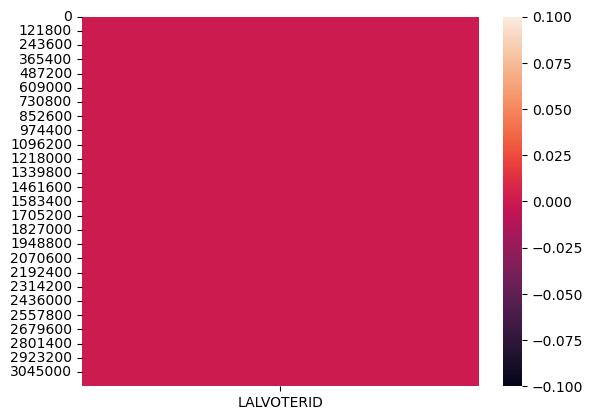

In [18]:
# check if there are any missing values in the voter ID column
# select OR voter IDs
ID_list = OR_df.select('LALVOTERID')
ID_list_pd = ID_list.toPandas()
# Convert all values to T/F
ID_tf = ID_list_pd.isnull()
# Plot it
sns.heatmap(data=ID_tf)

In [20]:
# count number of Counties in Oregon dataset
num_counties_OR = OR_df.select(countDistinct('County'))
num_counties_OR.show()

+----------------------+
|count(DISTINCT County)|
+----------------------+
|                    36|
+----------------------+



<AxesSubplot:>

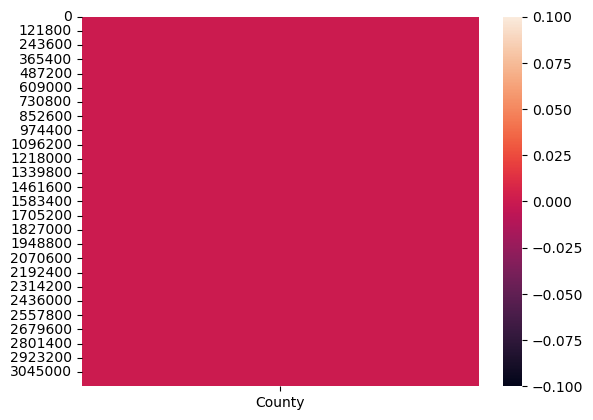

In [7]:
# check if there are any missing values in the county column
# select OR counties
county_list = OR_df.select('County')
county_list_pd = county_list.toPandas()
# Convert all values to T/F
county_tf = county_list_pd.isnull()
# Plot it
sns.heatmap(data=county_tf)

### Exploring Voter Turnout in Oregon

In [121]:
# get voter turnout stats per county in Oregon
OR_df = OR_df.withColumnRenamed("ElectionReturns_G16CountyTurnoutAllRegisteredVoters", "CountyTurnoutAll") \
    .withColumnRenamed("ElectionReturns_G16CountyTurnoutDemocrats", "CountyTurnoutDem") \
    .withColumnRenamed("ElectionReturns_G16CountyTurnoutIndependentsAllOthers", "CountyTurnoutOther") \
    .withColumnRenamed("ElectionReturns_G16CountyTurnoutRepublicans", "CountyTurnoutRep")
cty_voter_turnout_OR = OR_df.select('County', 'CountyTurnoutAll', 'CountyTurnoutDem',
                                'CountyTurnoutOther', 'CountyTurnoutRep').distinct().orderBy('County') # unique values per each county
cty_voter_turnout_OR.show()

+----------+----------------+----------------+------------------+----------------+
|    County|CountyTurnoutAll|CountyTurnoutDem|CountyTurnoutOther|CountyTurnoutRep|
+----------+----------------+----------------+------------------+----------------+
|     BAKER|             81%|             90%|               53%|            100%|
|    BENTON|             86%|             98%|               64%|             96%|
| CLACKAMAS|             82%|             95%|               57%|             97%|
|   CLATSOP|             81%|             99%|               54%|            100%|
|  COLUMBIA|             80%|             95%|               55%|             99%|
|      COOS|             79%|             98%|               51%|            100%|
|     CROOK|             82%|             95%|               55%|            100%|
|     CURRY|             81%|            100%|               53%|            100%|
| DESCHUTES|             83%|             98%|               59%|            100%|
|   

I find it interesting how high Republican Voter turnout is overall. All or almost all of registered republicans voted in each Oregon county.

In [122]:
# remove percentages and convert to integer values 
cty_voter_turnout_OR = cty_voter_turnout_OR.withColumn('CountyTurnoutPrcnt', translate(col('CountyTurnoutAll'),'%', ''))\
                    .withColumn('CountyTurnoutPrcntDem', translate(col('CountyTurnoutDem'),'%', ''))\
                    .withColumn('CountyTurnoutPrcntRep', translate(col('CountyTurnoutRep'),'%', ''))\
                    .withColumn('CountyTurnoutPrcntOther', translate(col('CountyTurnoutOther'),'%', ''))\
                    .drop('CountyTurnoutAll', 'CountyTurnoutDem', 'CountyTurnoutRep', 'CountyTurnoutOther')

from pyspark.sql.types import IntegerType
voter_turnout_OR_CLEAN = cty_voter_turnout_OR.withColumn('CountyTurnoutInt', cty_voter_turnout_OR['CountyTurnoutPrcnt'].cast(IntegerType()))\
                        .withColumn('CountyTurnoutDemInt', cty_voter_turnout_OR['CountyTurnoutPrcntDem'].cast(IntegerType()))\
                        .withColumn('CountyTurnoutRepInt', cty_voter_turnout_OR['CountyTurnoutPrcntRep'].cast(IntegerType()))\
                        .withColumn('CountyTurnoutOtherInt', cty_voter_turnout_OR['CountyTurnoutPrcntOther'].cast(IntegerType()))\
                        .drop('CountyTurnoutPrcnt', 'CountyTurnoutPrcntDem', 'CountyTurnoutPrcntRep', 'CountyTurnoutPrcntOther')
voter_turnout_OR_CLEAN.show()

+----------+----------------+-------------------+-------------------+---------------------+
|    County|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+----------+----------------+-------------------+-------------------+---------------------+
|     BAKER|              81|                 90|                100|                   53|
|    BENTON|              86|                 98|                 96|                   64|
| CLACKAMAS|              82|                 95|                 97|                   57|
|   CLATSOP|              81|                 99|                100|                   54|
|  COLUMBIA|              80|                 95|                 99|                   55|
|      COOS|              79|                 98|                100|                   51|
|     CROOK|              82|                 95|                100|                   55|
|     CURRY|              81|                100|                100|           

In [128]:
# find min and max for turnout across all categories
voter_turnout_OR_CLEAN.select(max('CountyTurnoutInt'), max('CountyTurnoutDemInt'), max('CountyTurnoutRepInt'), max('CountyTurnoutOtherInt')).show()
voter_turnout_OR_CLEAN.select(min('CountyTurnoutInt'), min('CountyTurnoutDemInt'), min('CountyTurnoutRepInt'), min('CountyTurnoutOtherInt')).show()


+---------------------+------------------------+------------------------+--------------------------+
|max(CountyTurnoutInt)|max(CountyTurnoutDemInt)|max(CountyTurnoutRepInt)|max(CountyTurnoutOtherInt)|
+---------------------+------------------------+------------------------+--------------------------+
|                   86|                     100|                     100|                        64|
+---------------------+------------------------+------------------------+--------------------------+



+---------------------+------------------------+------------------------+--------------------------+
|min(CountyTurnoutInt)|min(CountyTurnoutDemInt)|min(CountyTurnoutRepInt)|min(CountyTurnoutOtherInt)|
+---------------------+------------------------+------------------------+--------------------------+
|                   73|                      88|                      94|                        46|
+---------------------+------------------------+------------------------+--------------------------+



In [131]:
# find counties w min and max for all turnout
OR_turnout_max_min = voter_turnout_OR_CLEAN.filter((col('CountyTurnoutInt')==86) | (col('CountyTurnoutInt')==73))
OR_turnout_max_min.show()

+--------+----------------+-------------------+-------------------+---------------------+
|  County|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+--------+----------------+-------------------+-------------------+---------------------+
|  BENTON|              86|                 98|                 96|                   64|
|   GRANT|              86|                 94|                100|                   62|
|  HARNEY|              86|                 94|                100|                   59|
|UMATILLA|              73|                 88|                100|                   48|
+--------+----------------+-------------------+-------------------+---------------------+



The Oregon counties Benton, Grant, and Harney have the highest overall voter turnout in the state, while Umatilla has the lowest.

In [133]:
# find counties w min and max for dem turnout
OR_dem_turnout_max_min = voter_turnout_OR_CLEAN.filter((col('CountyTurnoutDemInt')==100) | (col('CountyTurnoutDemInt')==88))
OR_dem_turnout_max_min.show()

+--------+----------------+-------------------+-------------------+---------------------+
|  County|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+--------+----------------+-------------------+-------------------+---------------------+
|   CURRY|              81|                100|                100|                   53|
|UMATILLA|              73|                 88|                100|                   48|
+--------+----------------+-------------------+-------------------+---------------------+



The Oregon county Curry has the highest democrat voter turnout with 100% of all registered democrats voting, while Umatilla has the lowest democrat turnout at 88%.

In [136]:
# find counties w min and max for rep turnout
OR_rep_turnout_max_min = voter_turnout_OR_CLEAN.filter((col('CountyTurnoutRepInt')==100) | (col('CountyTurnoutRepInt')==94))
OR_rep_turnout_max_min.show()
OR_rep_turnout_max_min.filter(col('CountyTurnoutRepInt')==100).count()

+----------+----------------+-------------------+-------------------+---------------------+
|    County|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+----------+----------------+-------------------+-------------------+---------------------+
|     BAKER|              81|                 90|                100|                   53|
|   CLATSOP|              81|                 99|                100|                   54|
|      COOS|              79|                 98|                100|                   51|
|     CROOK|              82|                 95|                100|                   55|
|     CURRY|              81|                100|                100|                   53|
| DESCHUTES|              83|                 98|                100|                   59|
|     GRANT|              86|                 94|                100|                   62|
|    HARNEY|              86|                 94|                100|           

1

21 Oregon counties have a 100% voter turnout for registered Republican Voters, and only one county, Multnomah, had the minimum Republican voter turnout with 94%. 

In [137]:
# find counties w min and max for other turnout
OR_other_turnout_max_min = voter_turnout_OR_CLEAN.filter((col('CountyTurnoutOtherInt')==64) | (col('CountyTurnoutOtherInt')==46))
OR_other_turnout_max_min.show()

+-------+----------------+-------------------+-------------------+---------------------+
| County|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+-------+----------------+-------------------+-------------------+---------------------+
| BENTON|              86|                 98|                 96|                   64|
|MALHEUR|              76|                 93|                100|                   46|
+-------+----------------+-------------------+-------------------+---------------------+



The Oregon county with the maximum voter turnout for Independent/Other voters was Benton county (also one of the counties in the state with the highest overall voter turnout) and the county with the lowest Independent/Other voter turnout was Malheur.

### Exploring the 2016 General Election Outcome in Oregon

In [145]:
# get election results per county in Oregon
OR_df = OR_df.withColumnRenamed("ElectionReturns_G16_Cnty_Percent_Clinton_D", "Cnty_Percent_D") \
    .withColumnRenamed("ElectionReturns_G16_Cnty_Vote_Clinton_D", "Cnty_Vote_D") \
    .withColumnRenamed("ElectionReturns_G16_Cnty_Percent_Trump_R", "Cnty_Percent_R") \
    .withColumnRenamed("ElectionReturns_G16_Cnty_Vote_Trump_R", "Cnty_Vote_R")
election_results_OR = OR_df.select('County',
                                   'Cnty_Percent_D', 
                                   'Cnty_Vote_D',
                                   'Cnty_Percent_R', 
                                   'Cnty_Vote_R').distinct().orderBy('County')
election_results_OR.show()

+----------+--------------+-----------+--------------+-----------+
|    County|Cnty_Percent_D|Cnty_Vote_D|Cnty_Percent_R|Cnty_Vote_R|
+----------+--------------+-----------+--------------+-----------+
|     BAKER|           20%|       1797|           71%|       6218|
|    BENTON|           60%|      29193|           28%|      13445|
| CLACKAMAS|           48%|     102095|           41%|      88392|
|   CLATSOP|           47%|       9252|           41%|       8138|
|  COLUMBIA|           38%|      10167|           50%|      13217|
|      COOS|           33%|      10448|           57%|      17865|
|     CROOK|           22%|       2637|           70%|       8511|
|     CURRY|           34%|       4300|           57%|       7212|
| DESCHUTES|           43%|      42444|           46%|      45692|
|   DOUGLAS|           26%|      14096|           65%|      34582|
|   GILLIAM|           23%|        239|           66%|        671|
|     GRANT|           17%|        739|           74%|       3

In [146]:
# remove percentages and convert to integer values 
election_results_OR = election_results_OR.withColumn('Cnty_Prcnt_D', translate(col('Cnty_Percent_D'),'%', ''))\
                    .withColumn('Cnty_Prcnt_R', translate(col('Cnty_Percent_R'),'%', ''))\
                    .drop('Cnty_Percent_D', 'Cnty_Percent_R')

election_results_OR_CLEAN = election_results_OR.withColumn('Cnty_Prcnt_D_Int', election_results_OR['Cnty_Prcnt_D'].cast(IntegerType()))\
                        .withColumn('Cnty_Prcnt_R_Int', election_results_OR['Cnty_Prcnt_R'].cast(IntegerType()))\
                        .withColumn('Cnty_Vote_D_Int', election_results_OR['Cnty_Vote_D'].cast(IntegerType()))\
                        .withColumn('Cnty_Vote_R_Int', election_results_OR['Cnty_Vote_R'].cast(IntegerType()))\
                        .drop('Cnty_Prcnt_D', 'Cnty_Prcnt_R', 'Cnty_Vote_D', 'Cnty_Vote_R')
election_results_OR_CLEAN.show()

+----------+----------------+----------------+---------------+---------------+
|    County|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+----------+----------------+----------------+---------------+---------------+
|     BAKER|              20|              71|           1797|           6218|
|    BENTON|              60|              28|          29193|          13445|
| CLACKAMAS|              48|              41|         102095|          88392|
|   CLATSOP|              47|              41|           9252|           8138|
|  COLUMBIA|              38|              50|          10167|          13217|
|      COOS|              33|              57|          10448|          17865|
|     CROOK|              22|              70|           2637|           8511|
|     CURRY|              34|              57|           4300|           7212|
| DESCHUTES|              43|              46|          42444|          45692|
|   DOUGLAS|              26|              65|      

In [150]:
# find min and max for percent of votes for democrat and republican
election_results_OR_CLEAN.select(max('Cnty_Prcnt_D_Int'), max('Cnty_Prcnt_R_Int')).show()
election_results_OR_CLEAN.select(min('Cnty_Prcnt_D_Int'), min('Cnty_Prcnt_R_Int')).show()

+---------------------+---------------------+
|max(Cnty_Prcnt_D_Int)|max(Cnty_Prcnt_R_Int)|
+---------------------+---------------------+
|                   73|                   77|
+---------------------+---------------------+



+---------------------+---------------------+
|min(Cnty_Prcnt_D_Int)|min(Cnty_Prcnt_R_Int)|
+---------------------+---------------------+
|                   16|                   17|
+---------------------+---------------------+



In [153]:
# find counties w min and max percent of votes for Democrat
OR_D_Prcnt_max_min = election_results_OR_CLEAN.filter((col('Cnty_Prcnt_D_Int')==73) | (col('Cnty_Prcnt_D_Int')==16))
OR_D_Prcnt_max_min.show()
OR_R_Prcnt_max_min = election_results_OR_CLEAN.filter((col('Cnty_Prcnt_R_Int')==77) | (col('Cnty_Prcnt_R_Int')==17))
OR_R_Prcnt_max_min.show()

+---------+----------------+----------------+---------------+---------------+
|   County|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+---------+----------------+----------------+---------------+---------------+
|     LAKE|              16|              77|            639|           3022|
|MULTNOMAH|              73|              17|         292561|          67954|
+---------+----------------+----------------+---------------+---------------+



+---------+----------------+----------------+---------------+---------------+
|   County|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+---------+----------------+----------------+---------------+---------------+
|     LAKE|              16|              77|            639|           3022|
|MULTNOMAH|              73|              17|         292561|          67954|
+---------+----------------+----------------+---------------+---------------+



Multnomah county has the highest proportion of Democrat voters in the 2016 election and Lake county has the highest proportion of Republican voters.

### Exploring Median Education Years by County

<AxesSubplot:ylabel='County'>

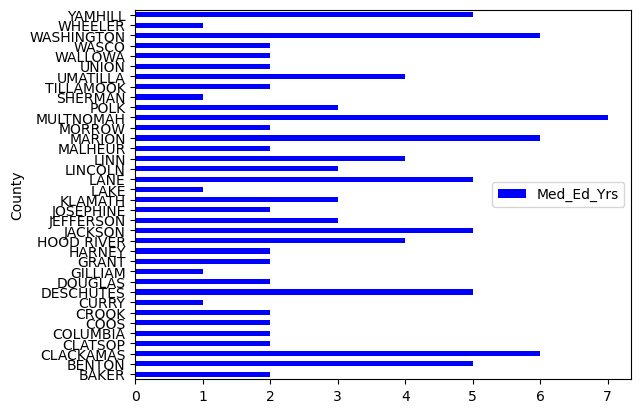

In [36]:
# plot median education years per county using CommercialData_AreaMedianEducationYears
OR_df = OR_df.withColumnRenamed('CommercialData_AreaMedianEducationYears', 'Med_Ed_Yrs')
ed_yrs_by_cty_OR = OR_df.groupBy('County').agg(countDistinct('Med_Ed_Yrs')).orderBy('County')
ed_yrs_by_cty_OR = ed_yrs_by_cty_OR.withColumn('Med_Ed_Yrs', col('count(Med_Ed_Yrs)')).drop(col('count(Med_Ed_Yrs)'))
ed_yrs_by_cty_pd_OR = ed_yrs_by_cty_OR.toPandas()
ed_yrs_by_cty_pd_OR.plot(kind='barh', x='County', y='Med_Ed_Yrs', color='blue')

In [90]:
# check count of counties for each value of median education years
ed_yrs_by_cty_cnt_OR = ed_yrs_by_cty_OR.groupBy('Med_Ed_Yrs').agg(countDistinct('County')).orderBy('Med_Ed_Yrs')
ed_yrs_by_cty_cnt_OR.show()

+----------+-------------+
|Med_Ed_Yrs|count(County)|
+----------+-------------+
|         1|            5|
|         2|           15|
|         3|            4|
|         4|            3|
|         5|            5|
|         6|            3|
|         7|            1|
+----------+-------------+



The median of education years for voters in a majority (15/36) of Oregon counties is 2 years.
The maximum median of education years in the state of Oregon is 7 years, and only one county (out of 36) has voters with that median.
The minimum median of education years in the state of Oregon is 1 year, and five counties (out of 36) have voters with that median.

In [154]:
# comparing voter turnout vs. median education years per county
ed_yr_turnout_OR = ed_yrs_by_cty_OR.join(voter_turnout_OR_CLEAN, 'County').orderBy('County').show()

# show voter turnout for counties w maximum median education year and minimum education year
# max_yr_turnout_OR = ed_yr_turnout_OR.where(col('Med_Ed_Yrs') == 7)

+----------+----------+----------------+-------------------+-------------------+---------------------+
|    County|Med_Ed_Yrs|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+----------+----------+----------------+-------------------+-------------------+---------------------+
|     BAKER|         2|              81|                 90|                100|                   53|
|    BENTON|         5|              86|                 98|                 96|                   64|
| CLACKAMAS|         6|              82|                 95|                 97|                   57|
|   CLATSOP|         2|              81|                 99|                100|                   54|
|  COLUMBIA|         2|              80|                 95|                 99|                   55|
|      COOS|         2|              79|                 98|                100|                   51|
|     CROOK|         2|              82|                 95|             

### Exploring Education Level by County

In [9]:
# clean the education level column
ed_lvl_combine = when(OR_df.CommercialData_Education.like('Grad Degree%'), 'Grad Degree')\
                .when(OR_df.CommercialData_Education.like('Bach Degree%'), 'Bach Degree')\
                .when(OR_df.CommercialData_Education.like('Vocational Technical Degree%'), 'Vocational Technical Degree')\
                .when(OR_df.CommercialData_Education.like('Some College%'), 'Some College')\
                .when(OR_df.CommercialData_Education.like('HS Diploma%'), 'HS Diploma')\
                .when(OR_df.CommercialData_Education.like('Less than HS Diploma%'), 'Less Than HS Diploma')\
                .otherwise('Null')
OR_df = OR_df.withColumn("Education_Lvl", ed_lvl_combine)

In [11]:
# find counts and proportions of each level of education for the state of Oregon
total_state_voters_OR = OR_df.select('LALVOTERID').count()
print('The total number of voters in the state of Oregon:', total_state_voters)

ed_lvl_st_cnt_OR = OR_df.groupBy(['Education_Lvl']).agg(countDistinct('LALVOTERID'))
ed_lvl_st_cnt_OR = ed_lvl_st_cnt.withColumnRenamed('count(LALVOTERID)', 'num_voters')
ed_lvl_state_OR = ed_lvl_st_cnt.withColumn('prcnt_of_total', round(((col('num_voters')/total_state_voters)*100), 2))
ed_lvl_state_OR.show()

The total number of voters in the state of Oregon: 3166785


+--------------------+----------+--------------+
|       Education_Lvl|num_voters|prcnt_of_total|
+--------------------+----------+--------------+
|Less Than HS Diploma|     77647|          2.45|
|          HS Diploma|    442607|         13.98|
|         Bach Degree|    457356|         14.44|
|         Grad Degree|    251347|          7.94|
|Vocational Techni...|      2721|          0.09|
|        Some College|    479671|         15.15|
|                Null|   1455436|         45.96|
+--------------------+----------+--------------+



<AxesSubplot:ylabel='Education_Lvl'>

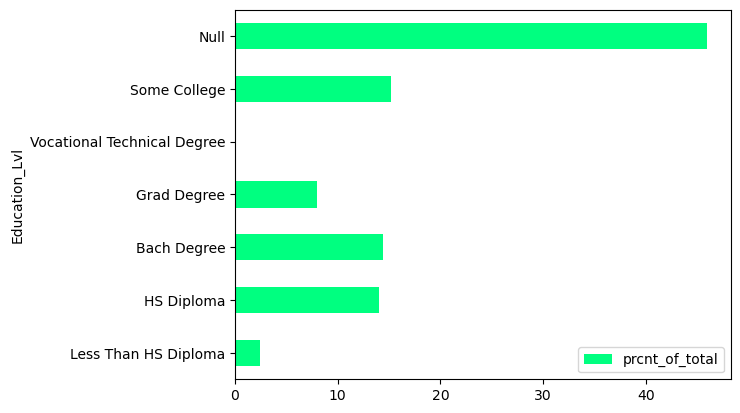

In [12]:
## visualize above
ed_lvl_state_pd_OR = ed_lvl_state_OR.toPandas()
ed_lvl_state_pd_OR.plot(kind='barh', x='Education_Lvl', y='prcnt_of_total', colormap='winter_r')

In [21]:
## find counts and proportions of each level of education for each county in the state of Oregon
county_voters_OR = OR_df.groupBy('County').agg(countDistinct('LALVOTERID'))
county_voters_OR = county_voters_OR.withColumn("voter_total", col('count(LALVOTERID)')).drop(col('count(LALVOTERID)')) 

ed_lvl_county_cnt_OR = OR_df.groupBy(['County','Education_Lvl']).agg(countDistinct('LALVOTERID'))
ed_lvl_county_cnt_OR = ed_lvl_county_cnt_OR.withColumn("ed_level_total", col('count(LALVOTERID)')).drop(col('count(LALVOTERID)')) 
ed_lvl_by_county_OR = ed_lvl_county_cnt_OR.join(county_voters_OR, 'County').orderBy('County')
ed_lvl_by_county_OR = ed_lvl_by_county_OR.withColumn("prcnt_of_total", round(((col("ed_level_total")/col("voter_total"))*100), 2))
ed_lvl_by_county_OR.show()

+---------+--------------------+--------------+-----------+--------------+
|   County|       Education_Lvl|ed_level_total|voter_total|prcnt_of_total|
+---------+--------------------+--------------+-----------+--------------+
|    BAKER|          HS Diploma|          2649|      13590|         19.49|
|    BAKER|         Grad Degree|           701|      13590|          5.16|
|    BAKER|        Some College|          2206|      13590|         16.23|
|    BAKER|                Null|          5720|      13590|         42.09|
|    BAKER|         Bach Degree|          1890|      13590|         13.91|
|    BAKER|Vocational Techni...|            15|      13590|          0.11|
|    BAKER|Less Than HS Diploma|           409|      13590|          3.01|
|   BENTON|         Grad Degree|          9590|      64136|         14.95|
|   BENTON|          HS Diploma|          5895|      64136|          9.19|
|   BENTON|        Some College|          8376|      64136|         13.06|
|   BENTON|Less Than HS D

<AxesSubplot:title={'center':'Null Values'}, ylabel='County'>

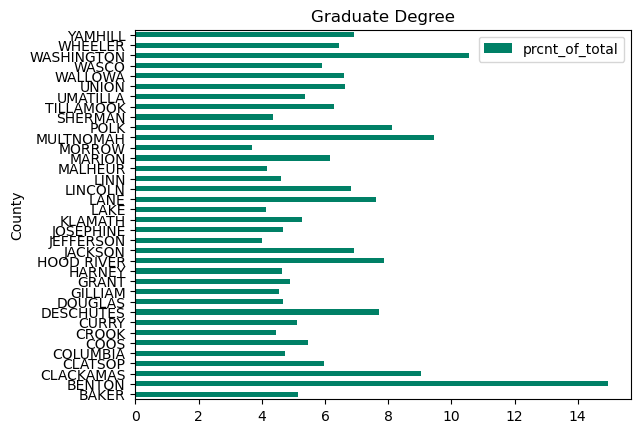

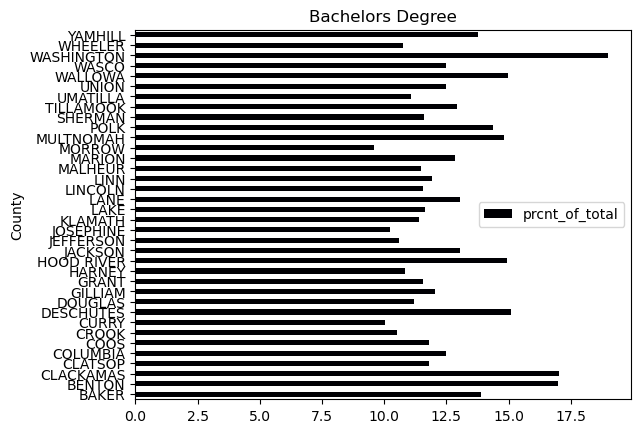

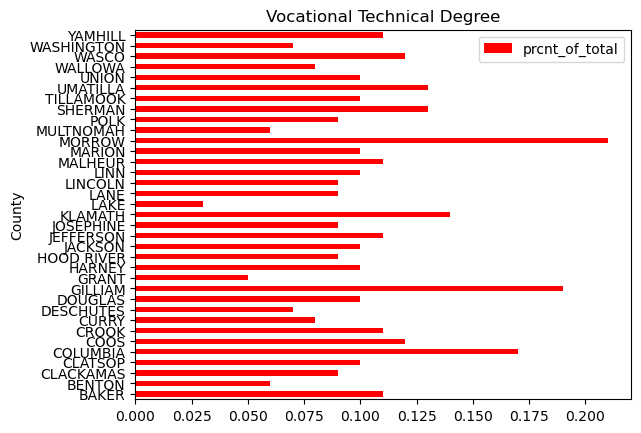

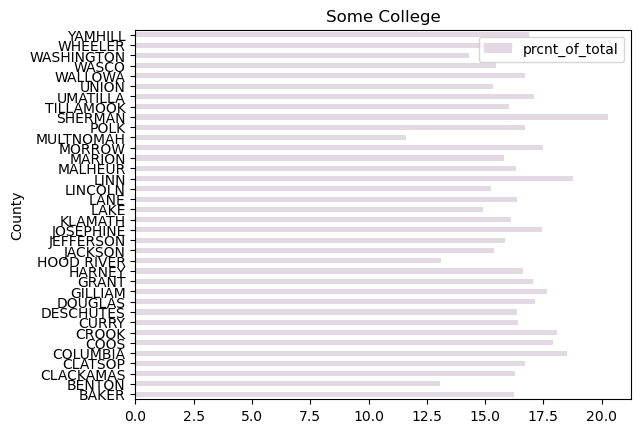

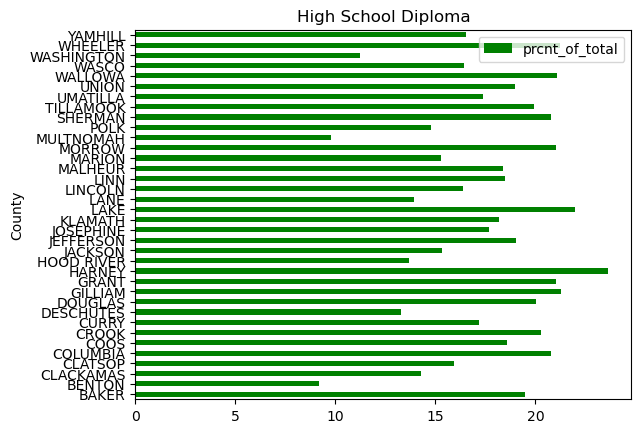

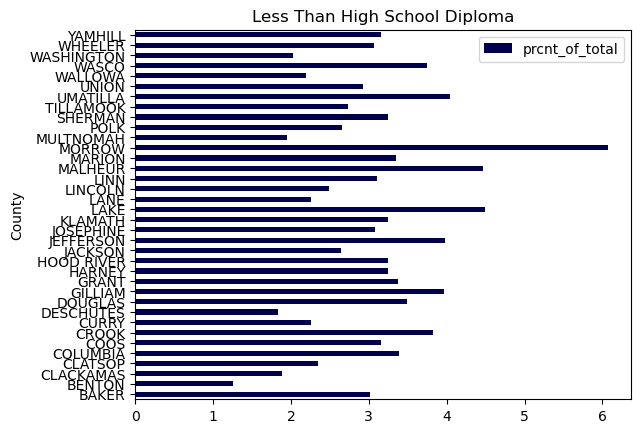

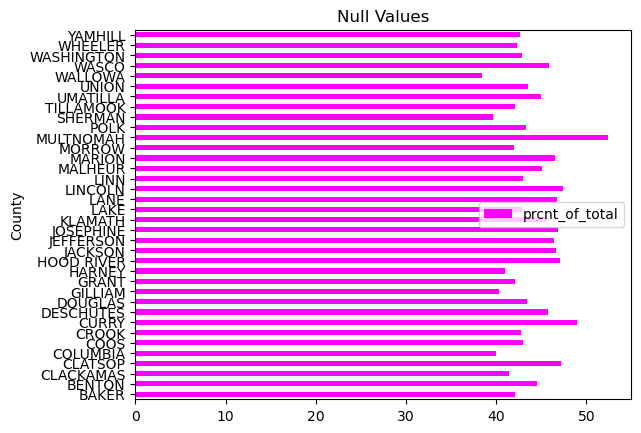

In [22]:
## visualize distribution across counties for each level of education

## distribution of grad degrees per county
grad_dgs_by_county_OR = ed_lvl_by_county_OR.filter(ed_lvl_by_county_OR.Education_Lvl == "Grad Degree")
grad_dgs_by_county_pd_OR = grad_dgs_by_county_OR.toPandas()
grad_dgs_by_county_pd_OR.plot.barh(x='County', y='prcnt_of_total', colormap='summer', title='Graduate Degree')

## distribution of bach degrees per county
bach_dgs_by_county_OR = ed_lvl_by_county_OR.filter(ed_lvl_by_county_OR.Education_Lvl == "Bach Degree")
bach_dgs_by_county_pd_OR = bach_dgs_by_county_OR.toPandas()
bach_dgs_by_county_pd_OR.plot.barh(x='County', y='prcnt_of_total', colormap='magma', title='Bachelors Degree')

## distribution of vocational technical degrees per county
voc_dgs_by_county_OR = ed_lvl_by_county_OR.filter(ed_lvl_by_county_OR.Education_Lvl == "Vocational Technical Degree")
voc_dgs_by_county_pd_OR = voc_dgs_by_county_OR.toPandas()
voc_dgs_by_county_pd_OR.plot.barh(x='County', y='prcnt_of_total', colormap='autumn', title='Vocational Technical Degree')

## distribution of some college per county
some_col_by_county_OR = ed_lvl_by_county_OR.filter(ed_lvl_by_county_OR.Education_Lvl == "Some College")
some_col_by_county_pd_OR = some_col_by_county_OR.toPandas()
some_col_by_county_pd_OR.plot.barh(x='County', y='prcnt_of_total', colormap='twilight', title='Some College')

## distribution of hs diploma per county
hs_dip_by_county_OR = ed_lvl_by_county_OR.filter(ed_lvl_by_county_OR.Education_Lvl == "HS Diploma")
hs_dip_by_county_pd_OR = hs_dip_by_county_OR.toPandas()
hs_dip_by_county_pd_OR.plot.barh(x='County', y='prcnt_of_total', colormap='ocean', title='High School Diploma')

## distribution of less than hs diploma per county
less_thn_hs_by_county_OR = ed_lvl_by_county_OR.filter(ed_lvl_by_county_OR.Education_Lvl == "Less Than HS Diploma")
less_thn_hs_by_county_pd_OR = less_thn_hs_by_county_OR.toPandas()
less_thn_hs_by_county_pd_OR.plot.barh(x='County', y='prcnt_of_total', colormap='seismic', title='Less Than High School Diploma')

## distribution of null education level per county
null_ed_lvl_by_county_OR = ed_lvl_by_county_OR.filter(ed_lvl_by_county_OR.Education_Lvl == "Null")
null_ed_lvl_by_county_pd_OR = null_ed_lvl_by_county_OR.toPandas()
null_ed_lvl_by_county_pd_OR.plot.barh(x='County', y='prcnt_of_total', colormap='spring', title='Null Values')